In [3]:
import numpy as np
import tensorflow as tf
import os

from skimage.metrics import structural_similarity as ssim   
from PIL import Image
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

2025-02-12 17:38:47.375860: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-12 17:38:48.013128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739381928.185258 4145323 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739381928.237696 4145323 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-12 17:38:48.731829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
#Define the CBR (Convolutional, Batch Normalization and ReLU block)
class CBR(keras.Model):
    
    def __init__(self,filters):
        super().__init__()
        self.Convolution = layers.Conv2D(filters = filters, kernel_size = 3, strides = 1, padding = 'same', use_bias = False)
        self.BatchN = layers.BatchNormalization()
        self.relu = layers.ReLU()

    def call(self,inputs):
        x = self.Convolution(inputs)
        x = self.BatchN(x)
        return self.relu(x)    
    
#Define the Network
inputs = keras.Input(shape = (None,None,3))

CBR1 = CBR(64)(inputs)

CBR2 = CBR(64)(CBR1)

Downsampling1 = layers.MaxPooling2D(pool_size = (2,2), strides = 2)(CBR2)
CBR3 = CBR(128)(Downsampling1)

CBR4 = CBR(128)(CBR3)

Downsampling2 = layers.MaxPooling2D(pool_size = (2,2), strides = 2)(CBR4)
CBR5 = CBR(256)(Downsampling2)

CBR6 = CBR(256)(CBR5)

Downsampling3 = layers.MaxPooling2D(pool_size = (2,2), strides = 2)(CBR6)
CBR7 = CBR(512)(Downsampling3)

Upsampling1 = layers.Conv2DTranspose(filters = 256, kernel_size = 2, strides = 2, padding = 'same')(CBR7)
#Add the Skip connections
combined_images1 = layers.Concatenate(axis = -1)([Upsampling1,CBR6])
CBR8 = CBR(512)(combined_images1)

CBR9 = CBR(256)(CBR8)

Upsampling2 = layers.Conv2DTranspose(filters = 128, kernel_size = 2, strides = 2, padding = 'same')(CBR9)
combined_images2 = layers.Concatenate(axis = -1)([Upsampling2,CBR4])
CBR10 = CBR(256)(combined_images2)

CBR11 = CBR(128)(CBR10)

Upsampling3 = layers.Conv2DTranspose(filters = 64, kernel_size = 2, strides = 2, padding = 'same')(CBR11)
combined_images3 = layers.Concatenate(axis = -1)([Upsampling3,CBR2])
CBR12 = CBR(128)(combined_images3)

CBR13 = CBR(64)(CBR12)

output = layers.Conv2D(filters = 1, kernel_size = 3, strides = 1, padding = 'same')(CBR13)
Mask = keras.Model(inputs = inputs, outputs = output, name = 'Test')

2025-02-12 15:35:33.387531: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
#Load the training data
def load_dataset(top_dir = 'input_data'):
    images_dataset = []
    for name in sorted(os.listdir(top_dir)):
        img = np.array(Image.open(os.path.join(top_dir,name)))
        img = img[:,:,:3]
        images_dataset.append(img)
    return images_dataset

def load_dataset_g(top_dir = 'input_data'):
    images_dataset = []
    for name in sorted(os.listdir(top_dir)):
        img = np.array(Image.open(os.path.join(top_dir,name)))
        images_dataset.append(img)
    return images_dataset

In [4]:
i = 4
Mask.load_weights('/users/lady6758/Mayowa_4YP_Code/ReTraining_ReTesting/Raindrop_Mask/5FoldCV/model'+str(i)+'/attentionweights_val.weights.h5')
val_index = np.load('/users/lady6758/Mayowa_4YP_Code/ReTraining_ReTesting/Raindrop_Mask/5FoldCV/model'+str(i)+'/val.npy')

In [5]:
#Load the dataset
rain_images_a = np.asarray(load_dataset(top_dir = '/data/lady6758/Parmeet_Datasets/NewDatasets/A_Qian_Cam_A+B/Real/rain_images'))
rain_images_b = np.asarray(load_dataset(top_dir = '/data/lady6758/Parmeet_Datasets/NewDatasets/B_Quan/Real+Synthetic/rain_images'))
rain_images = np.append(rain_images_a,rain_images_b,axis = 0)
del(rain_images_a)
del(rain_images_b)

y_mask_a = np.asarray(load_dataset_g(top_dir = '/data/lady6758/Parmeet_Datasets/NewDatasets/A_Qian_Cam_A+B/Real/KwonMask'))
y_mask_b = np.asarray(load_dataset_g(top_dir = '/data/lady6758/Parmeet_Datasets/NewDatasets/B_Quan/Real+Synthetic/KwonMask'))
y_mask = np.append(y_mask_a,y_mask_b,axis = 0)
del(y_mask_a)
del(y_mask_b)

rain_images = np.float32(rain_images)
y_mask = np.float32(y_mask)

rain_images /= 255
y_mask /= 255

np.random.seed(12345)
np.random.shuffle(rain_images)

np.random.seed(12345)
np.random.shuffle(y_mask)

In [6]:
rain_images_val = rain_images[val_index]
y_mask_val = y_mask[val_index]

In [7]:
no_of_images = rain_images_val.shape[0]
s = np.empty(shape = no_of_images)
m = np.empty(shape = no_of_images)
for i in range(no_of_images):
    img1 = rain_images_val[i]
    img1 = np.expand_dims(img1,axis = 0)
    generated_mask = np.squeeze(np.squeeze(Mask.predict(img1),axis = -1),axis = 0)

    mask = y_mask_val[i]
    s[i] = ssim(mask,generated_mask,data_range = 1, gaussian_weights=True, K1 = 0.01, K2 = 0.03, use_sample_covariance = False)
    m[i] = np.mean((mask - generated_mask)**2)
    print(s[i])
    print(m[i])
    print(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
0.6542910398500873
0.002401176607236266
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
0.9517134852614595
0.0005634085973724723
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
0.6725288057030717
0.00493259122595191
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
0.5821190589220754
0.004765807185322046
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
0.970858495633785
0.00047129401355050504
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
0.914855477870271
0.0015326343709602952
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
0.3029925391038343
0.009485863149166107
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
0.9595001989425113
0.000660483434330672
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
0.9543807843529041
0.0005616185371764004
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
0.7821108064846405
0.002022733446210623
9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
0.9600385810405898
0.0005246810615062714
10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
0.9714352167855455
0.0002315517922397703
11
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [4]:
def mean_std(array):
    mean = np.mean(array)
    std = np.std(array)
    print(f'Mean: {mean}')
    print(f'STD: {std}')

In [9]:
mean_std(s)

Mean: 0.8151546668701574
STD: 0.16933394778225236


In [10]:
mean_std(m)

Mean: 0.00388256239598744
STD: 0.007271293424410489


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


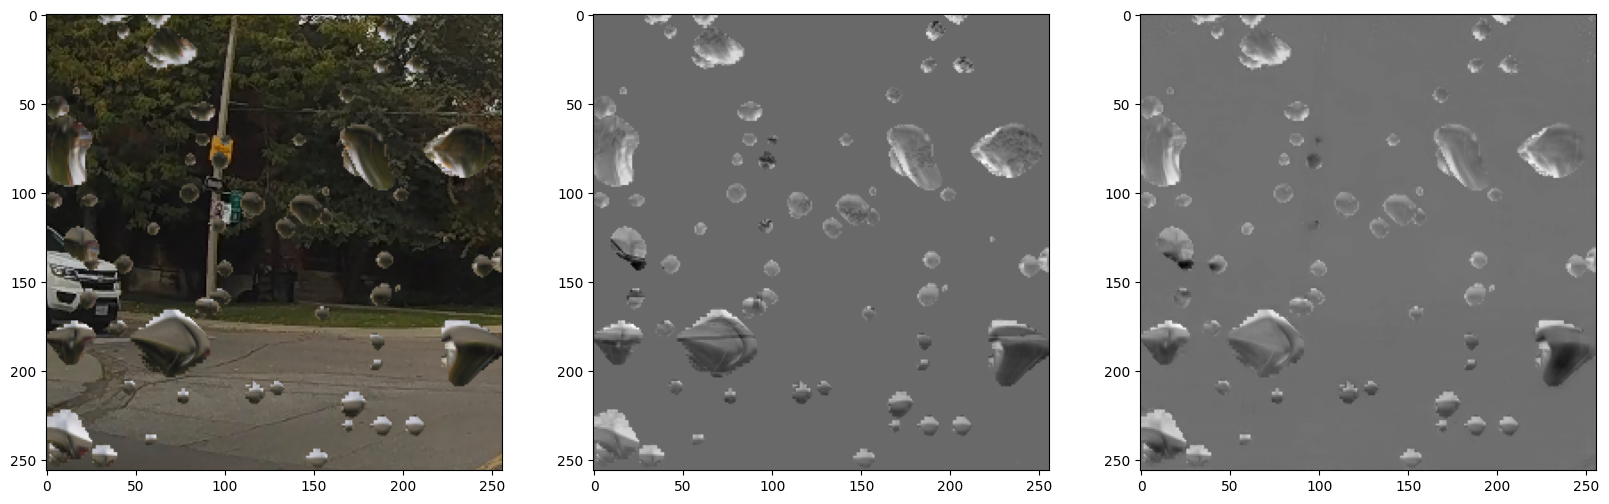

In [11]:
i = np.random.randint(0,16000)
img1 = np.float32(rain_images[i])
img1 = np.expand_dims(img1,axis = 0)
generated_mask = np.squeeze(np.squeeze(Mask.predict(img1),axis = -1),axis = 0)
mask = np.float32(y_mask[i])
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(rain_images[i])
plt.subplot(1,3,2)
plt.imshow(mask,cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(np.uint8(generated_mask*255),cmap = 'gray')

In [5]:
array = np.array([0.0077349, 0.0074809, 0.0075173, 0.0073002, 0.0074630])
mean_std(array)


Mean: 0.007499260000000001
STD: 0.00013937604672252705
